In [1]:
!pip install pandas seaborn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from IPython.core.display import HTML

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = ["Palatino"]

palette = ['#648FFF', '#DC267F', '#FFB000', '#785EF0', '#000000']
sns.set_palette(palette)

pd.options.display.max_rows = 500
pd.set_option('display.max_colwidth', None)


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
df = None
provers = ["z3_4_8_5", "z3_4_8_9", "z3_4_8_17", "cvc4_1_8", "cvc5_1_0_8", "gappa_1_4_0", "altergo_2_5_4"]
kinds = ["machine", "math"]

prover_names = {
    "z3_4_8_5": "Z3 4.8.5",
    "z3_4_8_9": "Z3 4.8.9",
    "z3_4_8_17": "Z3 4.8.17",
    "cvc4_1_8": "CVC4 1.8",
    "cvc5_1_0_8": "CVC5 1.0.8",
    "gappa_1_4_0": "Gappa 1.4.0",
    "altergo_2_5_4": "Alt-Ergo 2.5.4"
}

for kind in kinds:
    for prover in provers:
        csv = pd.read_csv("../results_" + kind + "_" + prover + ".csv")
        
        # ArrayReverse test is wrong, exclude it 
        csv = csv.loc[~csv.goal.str.contains(".ArrayReverse.", regex=False) , :]
        csv["result"] = csv["result"].apply(lambda c: int(c == "Valid"))
        
        csv = csv.rename(columns={
            'result': 'result_' + kind + "_" + prover,
            'time': 'time_' + kind + "_" + prover,
            'steps': 'steps_' + kind + "_" + prover,
        })
        
        if df is None:
            df = csv
        else:
            df = df.merge(csv, how='outer', on=['file', 'kind', 'goal'])


df_stats = pd.read_csv('../extended_stats.csv')
df_stats.goal = df_stats.goal.apply(lambda x: x.replace("[", "R").replace(" ", "'020"))

df = df_stats.join(df.set_index(["file", "goal"]), on=["file", "goal"], how="right")
df

,file,goal,heap_count,missing_inv_count,category1,category2,category3,kind,result_machine_z3_4_8_5,time_machine_z3_4_8_5,...,steps_math_cvc4_1_8,result_math_cvc5_1_0_8,time_math_cvc5_1_0_8,steps_math_cvc5_1_0_8,result_math_gappa_1_4_0,time_math_gappa_1_4_0,steps_math_gappa_1_4_0,result_math_altergo_2_5_4,time_math_altergo_2_5_4,steps_math_altergo_2_5_4
719,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.switchInteger()V,2,0,branch,arithmetic,comparison,cfg,1,0.05,...,51479,1,0.08,44055,0,0.0,NaN,1,0.03,189
717,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.<clinit>()V,1,0,spec,NaN,NaN,cfg,1,0.05,...,49880,1,0.08,42843,0,0.0,NaN,1,0.03,188
718,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.<init>()V,0,0,spec,NaN,NaN,cfg,1,0.04,...,39608,1,0.06,37244,0,0.0,NaN,1,0.02,190
720,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.switchYieldInteger()V,2,0,branch,arithmetic,comparison,cfg,1,0.05,...,51479,1,0.08,44055,0,0.0,NaN,1,0.03,189
722,test-java-17/src/main/java/byteback/test/typeinference/Output/Basic.java.tmp.mlcfg,byteback.test.typeinference.Basic.inferPrimitives()V,0,0,references,comparison,NaN,cfg,1,0.03,...,34569,1,0.03,31453,1,0.0,NaN,1,0.02,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,test-kotlin-1.8.0/src/main/kotlin/byteback/test/controlflow/Output/Basic.kt.tmp.mlcfg,byteback.test.controlflow.Basic.emptyWhile(Z)V,0,0,loop,NaN,NaN,cfg,1,0.03,...,36947,1,0.05,36108,0,0.0,NaN,1,0.02,62
108,test-kotlin-1.8.0/src/main/kotlin/byteback/test/controlflow/Output/Basic.kt.tmp.mlcfg,byteback.test.controlflow.Basic.emptyDoWhile(Z)V,0,0,loop,NaN,NaN,cfg,1,0.03,...,36947,1,0.05,36108,0,0.0,NaN,1,0.02,62
122,test-kotlin-1.8.0/src/main/kotlin/byteback/test/controlflow/Output/Basic.kt.tmp.mlcfg,byteback.test.controlflow.Basic.sum(II)I,0,0,loop,arithmetic,NaN,cfg,1,0.03,...,30488,1,0.02,18493,1,0.0,NaN,1,0.01,52
105,test-kotlin-1.8.0/src/main/kotlin/byteback/test/controlflow/Output/Basic.kt.tmp.mlcfg,byteback.test.controlflow.Basic.empty()V,0,0,spec,NaN,NaN,cfg,1,0.02,...,30488,1,0.02,18493,1,0.0,NaN,1,0.02,52


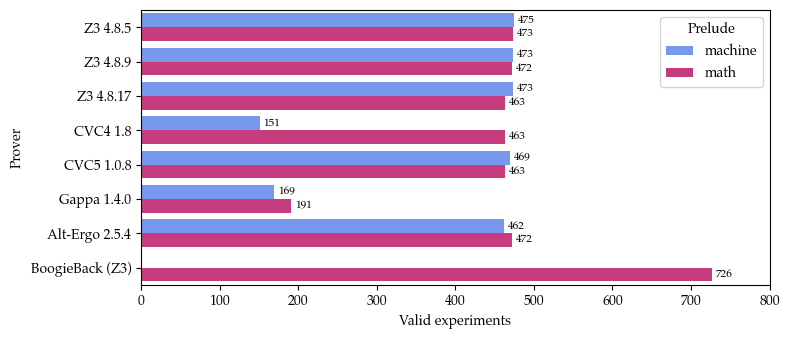

In [3]:
def results_main_plot(df, ax, limit):
    df_sum = pd.DataFrame(df.filter(regex=r'^result_').reset_index(drop=True).sum(), columns=["Valid experiments"])
    df_sum["Prelude"] = df_sum.index.map(lambda x: x.replace("result_", "").split("_", 1)[0])
    df_sum["Prover"] = df_sum.index.map(lambda x: x.replace("result_", "").split("_", 1)[1]
                                        .replace("_", " ", 1)
                                        .replace("cvc", "CVC")
                                        .replace("z3", "Z3")
                                        .replace("gappa", "Gappa")
                                        .replace("altergo", "Alt-Ergo")
                                        .replace("_", "."))
    #df_sum["version"] = df_sum.index.map(lambda x: x.replace("result_", "").split("_", 1)[2])
    df_sum.loc["total", ["Valid experiments", "Prelude", "Prover"]] = [len(df.index), "math", "BoogieBack (Z3)"]
    
    sns.barplot(data=df_sum, ax=ax, x="Valid experiments", y="Prover", hue="Prelude")
    ax.set_xlim([0, limit])
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontsize=8)

fig, ax = plt.subplots(figsize=(8, 3.5))
results_main_plot(df, ax, 800)
fig.align_ylabels()
plt.tight_layout()
plt.savefig('/Users/maggicl/git/seminar/thesis/figures/06-analysis/results-main.pgf')
plt.show()

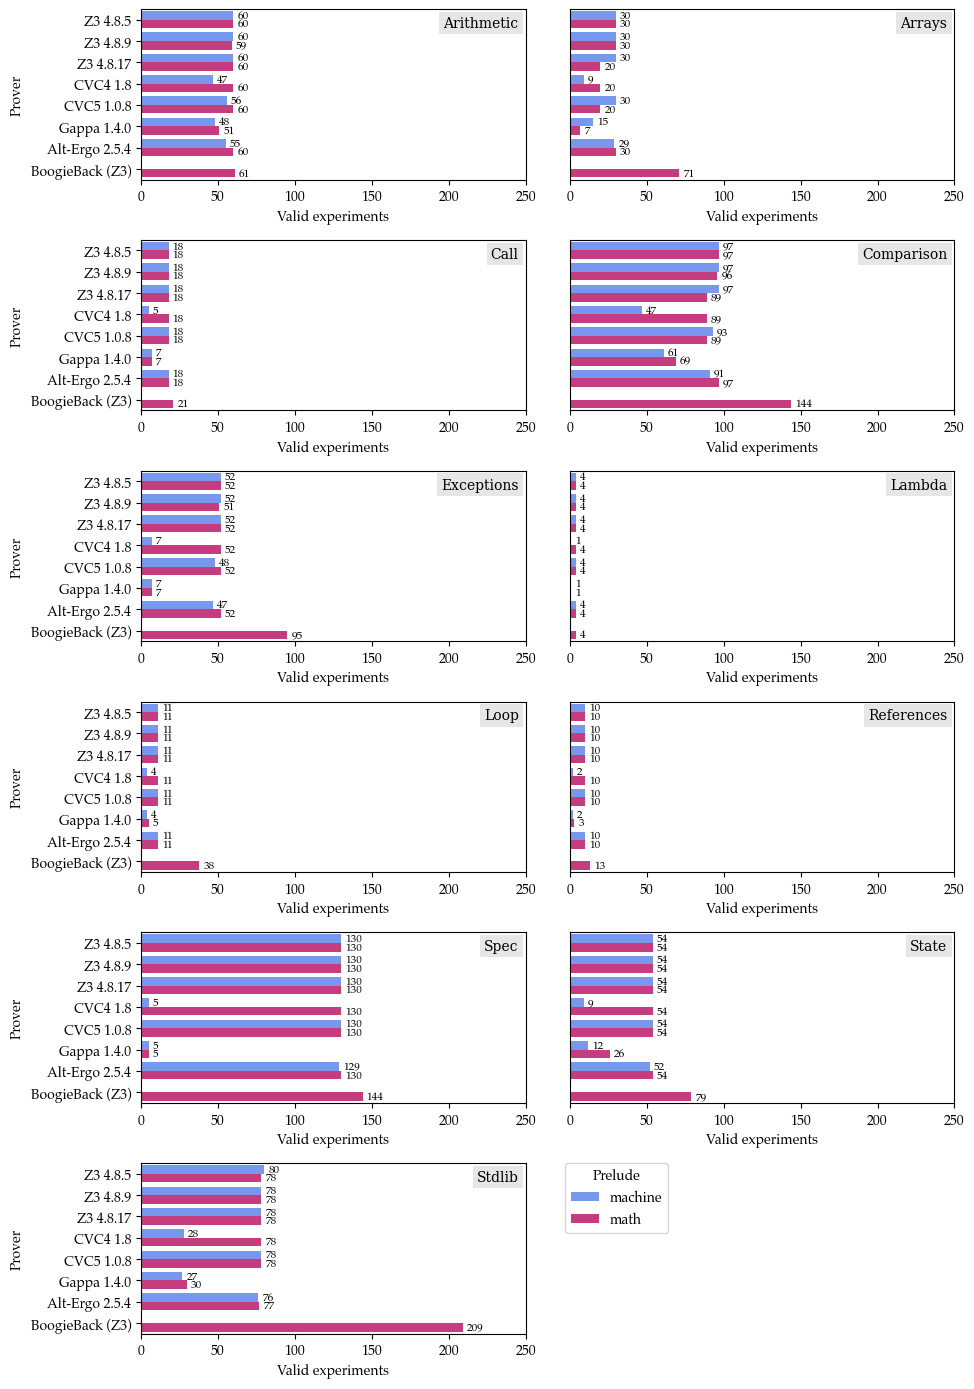

In [4]:
categories = ['arithmetic', 'arrays', 'call', 'comparison', 'exceptions', 'lambda', 'loop', 'references', 'spec', 'state', 'stdlib']

def of_category(df, category):
    return (df["category1"] == category) | (df["category2"] == category) | (df["category3"] == category)

fig = plt.figure(figsize=(10, 14))

old_ax = None

for i, cat in enumerate(categories):
    ax = fig.add_subplot(6,2,i + 1, sharey=old_ax)
    cat = categories[i]
    results_main_plot(df.loc[of_category(df, cat)], ax, 250)
    ax.get_legend().remove()
    old_ax = ax

    if i % 2 == 1:
        ax.get_yaxis().set_visible(False)

    ax.annotate(
        cat.capitalize(),
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+27.2, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', horizontalalignment='right', fontfamily='serif',
        bbox=dict(facecolor='0.9', edgecolor='none', pad=3.0))
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][0:1]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.68, 0.17), title="Prelude")
fig.align_ylabels()
plt.tight_layout()
plt.savefig('/Users/maggicl/git/seminar/thesis/figures/06-analysis/results-categories.pgf')
plt.show()

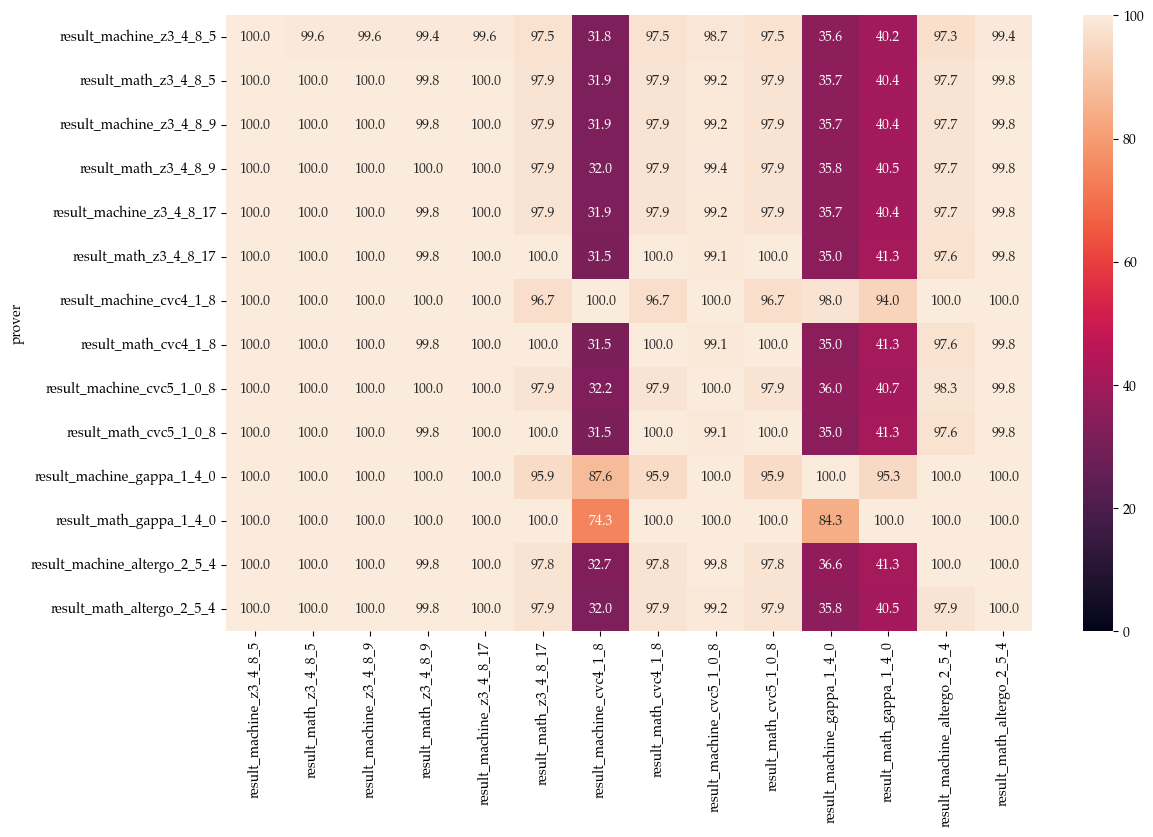

In [5]:
dfs = []

columns = [f"result_{kind}_{prover}" for prover in provers for kind in kinds]

for column in columns:
    tab = df.loc[df[column] == 1, columns].copy(deep=True)
    count = sum(df[column] == 1)
    tab["prover"] = column
    tab = tab.groupby(["prover"]).sum()
    tab = tab.apply(lambda r: r.apply(lambda c: 100 * c / count))
    dfs.append(tab)

plt.figure(1,(13,8))
df_all = pd.concat(dfs)

sns.heatmap(df_all, annot=True, fmt="2.1f", vmin=0, vmax=100)
plt.show()

/var/folders/84/pwxv9qyd68qfk56f26nwlpgm0000gp/T/ipykernel_6043/1547114650.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/84/pwxv9qyd68qfk56f26nwlpgm0000gp/T/ipykernel_6043/1547114650.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


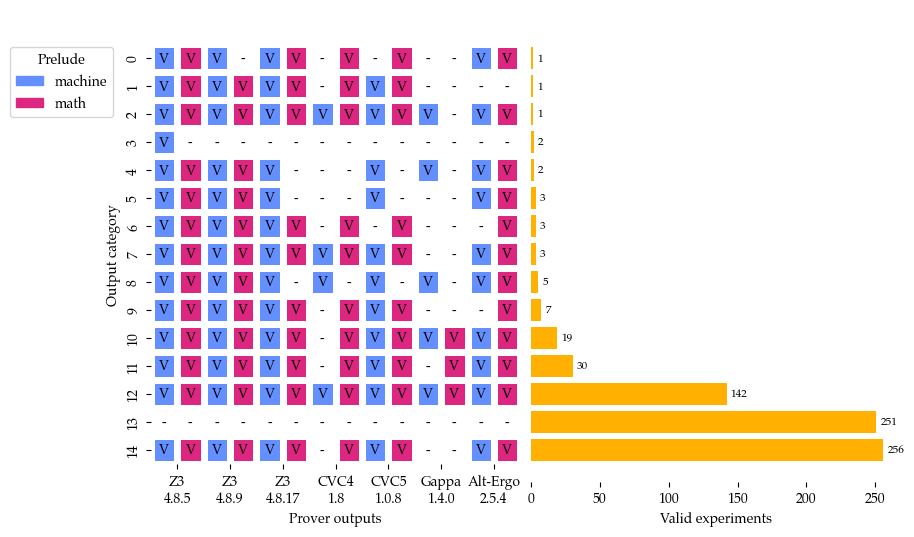

In [17]:
df_res = df.loc[:, columns] \
    .assign(count=1) \
    .groupby(columns).sum().reset_index() \
    .sort_values("count").reset_index(drop=True)

def to_name(col):
    if col == "count":
        return "count"
    
    col = col.replace("result_", "")
    col = col.split("_", 1)
    return prover_names[col[1]].replace(" ", "\n") # ({col[0]})"

df_res.loc[:, [c for c in columns if c.startswith("result_machine_")]] *= 2

old_columns = df_res.columns
df_res.columns = df_res.columns.map(to_name)



#display(df_res.transpose().map)

def heatmap(*args, **kwargs):
    dfa = df_res.copy()
    del dfa["count"]

    annot = dfa.apply(lambda r: r.apply(lambda c: 'V' if c else '-'))
    
    hm = sns.heatmap(dfa, fmt="", annot=annot, \
                     vmin=0, vmax=2, cbar=False, \
                     square=False, cmap=["white", palette[1], palette[0]], \
                     annot_kws={'color': 'black', 'fontweight': 'bold'}, \
                     linewidth=5, **kwargs)

fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(5, 2, height_ratios=[1,2,1000,2,1], width_ratios=[1,1], wspace=0.03, left=0.15, bottom=0.18)

ax1 = fig.add_subplot(gs[2, 0])
ax2 = fig.add_subplot(gs[1:4, 1])
pad1 = fig.add_subplot(gs[0, 0])
pad2 = fig.add_subplot(gs[1, 0])
pad3 = fig.add_subplot(gs[3, 0])
pad4 = fig.add_subplot(gs[4, 0])
pad1.axis('off')
pad2.axis('off')
pad3.axis('off')
pad4.axis('off')

heatmap(ax=ax1)

provers = [x for x in df_res.columns.drop_duplicates().to_list() if x != "count"]

ax1.get_xaxis().set_ticks(np.arange(0, len(provers)) * 2 + 1, labels=provers, minor=False, rotation=0)
ax1.set_xlabel('Prover outputs')
ax1.set_ylabel('Output category')

series = df_res['count']
ys = series.index.to_list()
y_pos = np.arange(len(ys))
ax2.barh(y_pos, series, align='center', color=palette[2], height=0.8)
ax2.set_yticks(y_pos, labels=ys)
ax2.invert_yaxis()
ax2.set_xlabel('Valid experiments')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_visible(False)
#ax2.set(yticklabels=[])

for container in ax2.containers:
    ax2.bar_label(container, padding=3, fontsize=8)

machine_patch = mpatches.Patch(color=palette[0], label='machine')
math_patch = mpatches.Patch(color=palette[1], label='math')
ax1.legend(handles=[machine_patch, math_patch], loc='upper left', bbox_to_anchor=(-0.4, 1.01), title="Prelude")

plt.tight_layout()
fig.show()
plt.savefig('/Users/maggicl/git/seminar/thesis/figures/06-analysis/results-by-output.pgf')

In [19]:
dfs = []

df_res.columns = old_columns

for i, row in df_res.iterrows():
    cond = None
    for idx, value in row.items():
        if idx == "count":
            continue

        this_cond = df[idx] == value

        if cond is None:
            cond = this_cond
        else:
            cond = cond & this_cond

    df_row = pd.DataFrame(row).transpose()
    df_row.style.hide(axis="index")

    display(HTML(f"<hr><h1>Result kind row {i}:</h1>"))
    display(df_row)
    df_resx = df[cond].loc[:, ["kind", "file", "goal"]].sort_values(["kind", "file", "goal"]).reset_index(drop=True)
    display(df_resx)
    dfs.append(df_resx)
    df_resx.to_csv(f"{i}.csv", index=False)

,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
0,2,1,2,0,2,1,0,1,0,1,0,0,2,1,1


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
1,2,1,2,1,2,1,0,1,2,1,0,0,0,0,1


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
2,2,1,2,1,2,1,2,1,2,1,2,0,2,1,1


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
4,2,1,2,1,2,0,0,0,2,0,2,0,2,1,2


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
5,2,1,2,1,2,0,0,0,2,0,0,0,2,1,3


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
6,2,1,2,1,2,1,0,1,0,1,0,0,0,1,3


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
7,2,1,2,1,2,1,2,1,2,1,0,0,2,1,3


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
8,2,1,2,1,2,0,2,0,2,0,2,0,2,1,5


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
9,2,1,2,1,2,1,0,1,2,1,0,0,0,1,7


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
10,2,1,2,1,2,1,0,1,2,1,2,1,2,1,19


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
11,2,1,2,1,2,1,0,1,2,1,0,1,2,1,30


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
12,2,1,2,1,2,1,2,1,2,1,2,1,2,1,142


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,251


,kind,file,goal
0,cfg,test-java-17/src/main/java/byteback/test/examples/Output/ReadResource.java.tmp.mlcfg,byteback.test.examples.ReadResource.readInto(LByteback.Test.Examples.ReadResource$Resource;RI)V
1,cfg,test-java-17/src/main/java/byteback/test/examples/Output/Summary.java.tmp.mlcfg,byteback.test.examples.Summary.summary(RI)I
2,cfg,test-java-17/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.tryWithResourcesFinallyOnExistingResourceClosesResource()V
3,cfg,test-java-17/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.tryWithResourcesOnExistingResourceClosesResource()V
4,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/BinarySearch.java.tmp.mlcfg,byteback.test.algorithm.BinarySearch.search(RIIII)I
5,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleInsertionSort.java.tmp.mlcfg,byteback.test.algorithm.DoubleInsertionSort.sort(RD)V
6,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleMax.java.tmp.mlcfg,byteback.test.algorithm.DoubleMax.max(RD)D
7,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleSelectionSort.java.tmp.mlcfg,byteback.test.algorithm.DoubleSelectionSort.minimum(RDI)I
8,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleSelectionSort.java.tmp.mlcfg,byteback.test.algorithm.DoubleSelectionSort.sort(RD)V
9,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleSelectionSort.java.tmp.mlcfg,byteback.test.algorithm.DoubleSelectionSort.swap(RDII)V


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
14,2,1,2,1,2,1,0,1,2,1,0,0,2,1,256


,kind,file,goal


,result_machine_z3_4_8_5,result_math_z3_4_8_5,result_machine_z3_4_8_9,result_math_z3_4_8_9,result_machine_z3_4_8_17,result_math_z3_4_8_17,result_machine_cvc4_1_8,result_math_cvc4_1_8,result_machine_cvc5_1_0_8,result_math_cvc5_1_0_8,result_machine_gappa_1_4_0,result_math_gappa_1_4_0,result_machine_altergo_2_5_4,result_math_altergo_2_5_4,count
0,2,1,2,0,2,1,0,1,0,1,0,0,2,1,1
1,2,1,2,1,2,1,0,1,2,1,0,0,0,0,1
2,2,1,2,1,2,1,2,1,2,1,2,0,2,1,1
3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,2,1,2,1,2,0,0,0,2,0,2,0,2,1,2
5,2,1,2,1,2,0,0,0,2,0,0,0,2,1,3
6,2,1,2,1,2,1,0,1,0,1,0,0,0,1,3
7,2,1,2,1,2,1,2,1,2,1,0,0,2,1,3
8,2,1,2,1,2,0,2,0,2,0,2,0,2,1,5
9,2,1,2,1,2,1,0,1,2,1,0,0,0,1,7


ValueError: Could not interpret value `heap_count` for `y`. An entry with this name does not appear in `data`.

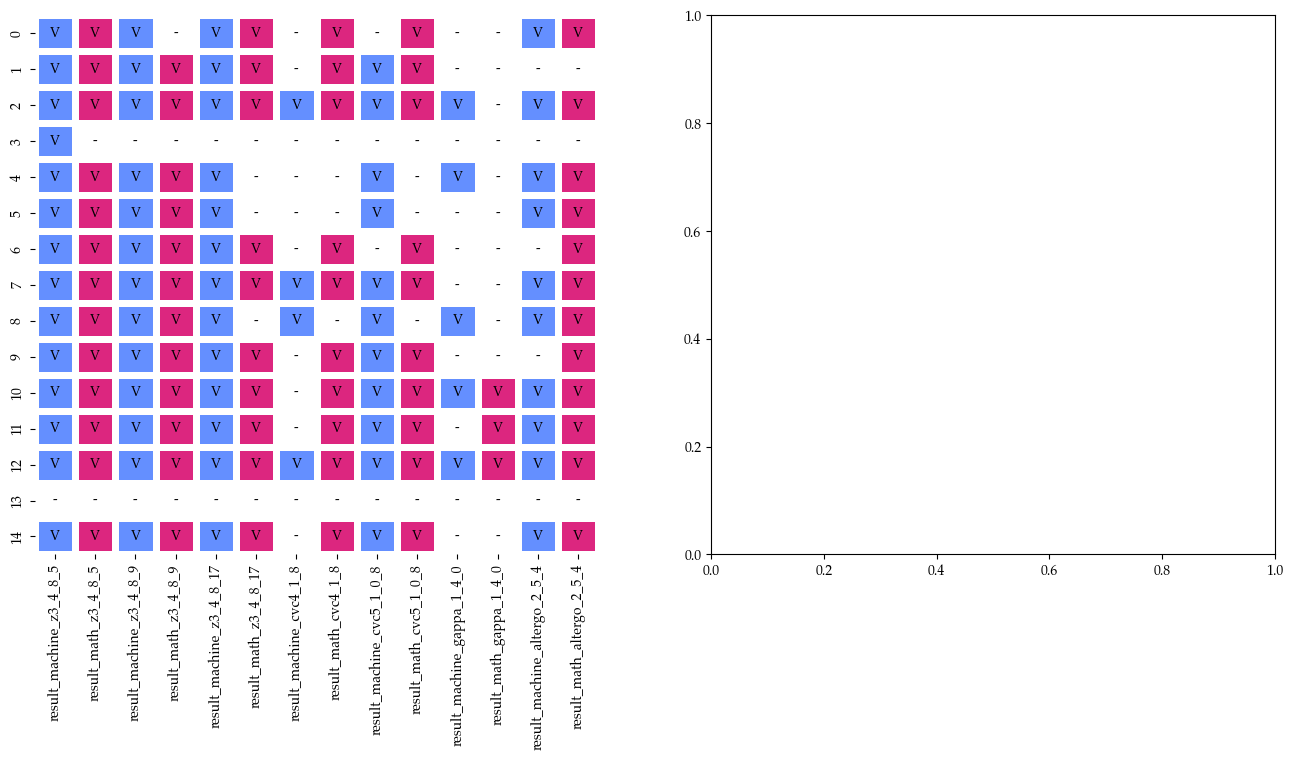

In [27]:
display(df_res)

fig, ax = plt.subplots(1, 2, figsize=(16,7))
heatmap(ax=ax[0])
sns.boxplot(data=df_res.reset_index(), x="index", y="heap_count", ax=ax[1])
plt.show()

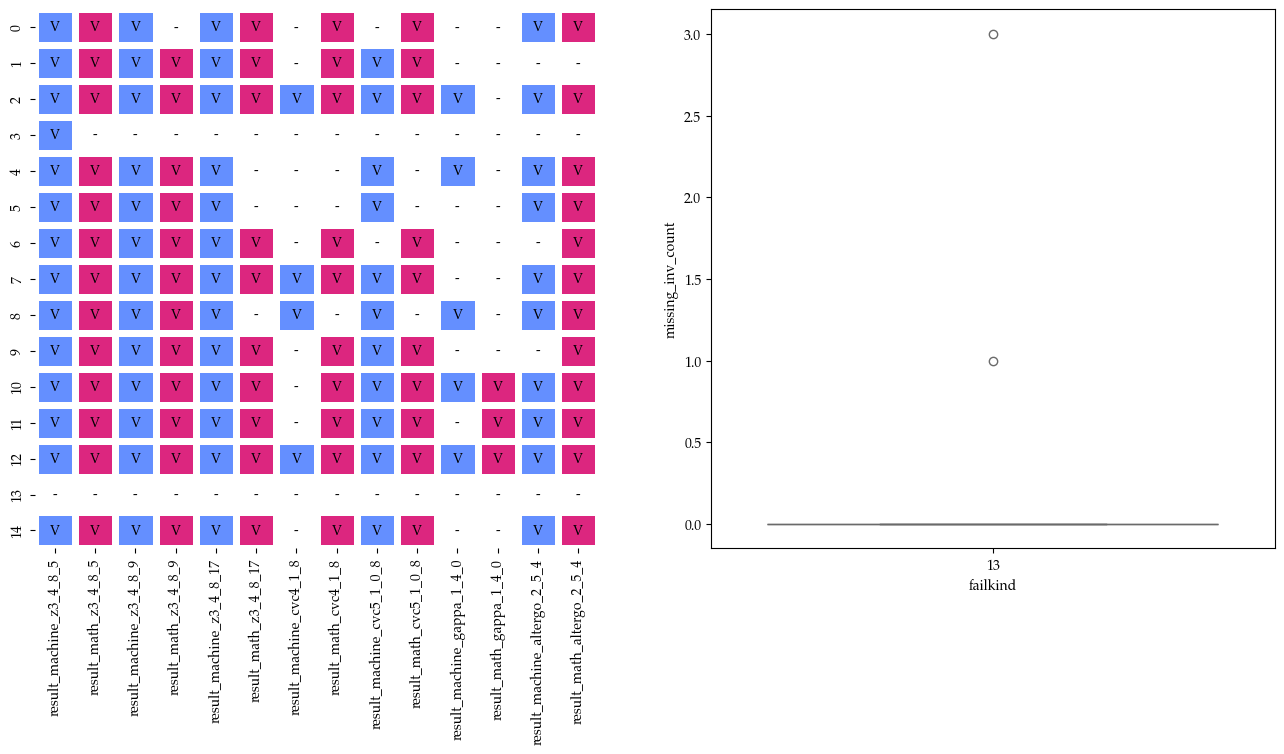

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))
heatmap(ax=ax[0])
sns.boxplot(data=df_dist, x="failkind", y="missing_inv_count", ax=ax[1])
plt.show()

In [ ]:
# Number of tests that pass for every prover where they pass

columns = [f"result_{k}_{p}" for k in kinds for p in provers]

df_join_extended = df_stats.reset_index().join(df_res_all.set_index(["file", "goal"]), on=["file", "goal"], how="right")
df_join_extended = df_join_extended.loc[df_join_extended.kind.notna()]
df_join_extended = df_join_extended.sort_values("missing_inv_count", ascending=False)

categories = ['arithmetic', 'arrays', 'call', 'comparison', 'dud', 'exceptions', 'lambda', 'loop', 'references', 'state', 'stdlib']

def of_category(df, category):
    return (df["category1"] == category) | (df["category2"] == category) | (df["category3"] == category)

for c in categories:
    # Percentage of tests that pass for every prover where they pass

    columns = [f"result_{k}_{p}" for k in kinds for p in provers]
    df_res_cat = df_join_extended.loc[of_category(df_join_extended, c), :].filter(regex=r'^result_').reset_index()
    
    dfs_cat = []
    
    for column in columns:
        tab = df_res_cat[df_res_cat[column] == 1].copy(deep=True)
        tab["prover"] = column
        tab = tab.groupby(["prover"]).sum()
        del tab["index"]
        dfs_cat.append(tab)
    
    df_cat_all = pd.concat(dfs_cat)
    
    display(HTML(f"<hr><h1>{c}</h1>"))

    fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=True)
    sns.heatmap(df_cat_all, annot=True, fmt="2.0f", ax=ax[0], vmin=0)

    df_res_cat = df_join_extended.loc[of_category(df_join_extended, c), :].filter(regex=r'^result_').reset_index()
    
    dfs_cat = []
    
    for column in columns:
        tab = df_res_cat[df_res_cat[column] == 1].copy(deep=True)
        count = len(tab.index)
        tab["prover"] = column
        tab = tab.groupby(["prover"]).sum()
        tab = tab.apply(lambda r: r.apply(lambda c: 100 * c / count))
        del tab["index"]
        dfs_cat.append(tab)
    
    df_cat_all = pd.concat(dfs_cat)
    sns.heatmap(df_cat_all, annot=True, fmt="2.0f", ax=ax[1], vmin=0, vmax=100)  
    plt.show()

In [ ]:
import numpy as np